<a href="https://colab.research.google.com/github/jaewookng/ArMD-NN/blob/main/ArMD-NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Images in dataset directory:
['491_right.jpg', '492_right.jpg', '494_right.jpg', '495_right.jpg', '495_left.jpg', '493_left.jpg', '498_left.jpg', '496_left.jpg', '496_right.jpg', '498_right.jpg']
Number of AMD images: 551
Number of Normal images: 595
Total dataset size: 3901
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 104s 855ms/step - accuracy: 0.8241 - loss: 0.3992 - val_accuracy: 0.8910 - val_loss: 0.1935
Epoch 2/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 48s 619ms/step - accuracy: 0.8787 - loss: 0.2250 - val_accuracy: 0.9215 - val_loss: 0.1616
Epoch 3/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 47s 599ms/step - accuracy: 0.9237 - loss: 0.1730 - val_accuracy: 0.9199 - val_loss: 0.1771
Epoch 4/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 48s 618ms/step - accuracy: 0.9223 - loss: 0.1697 - val_accuracy: 0.9263 - val_loss: 0.1549
Epoch 5/15
78/78 ━━━━━━━━━━━━━━━━━━━━ 48s 616ms/step - accuracy: 0.9527 - loss: 0.1156 - val_accuracy: 0.9279 - val_loss: 0.1385
E

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,342,277 (302.67 MB)

 Trainable params: 26,447,425 (100.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,894,852 (201.78 MB)

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - accuracy: 0.9744 - loss: 0.0690
Test Loss: 0.0919935554265976
Test Accuracy: 0.9718309640884399
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step
Confusion Matrix:
[[117   2]
 [ 19 643]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       119
           1       1.00      0.97      0.98       662

    accuracy                           0.97       781
   macro avg       0.93      0.98      0.95       781
weighted avg       0.98      0.97      0.97       781



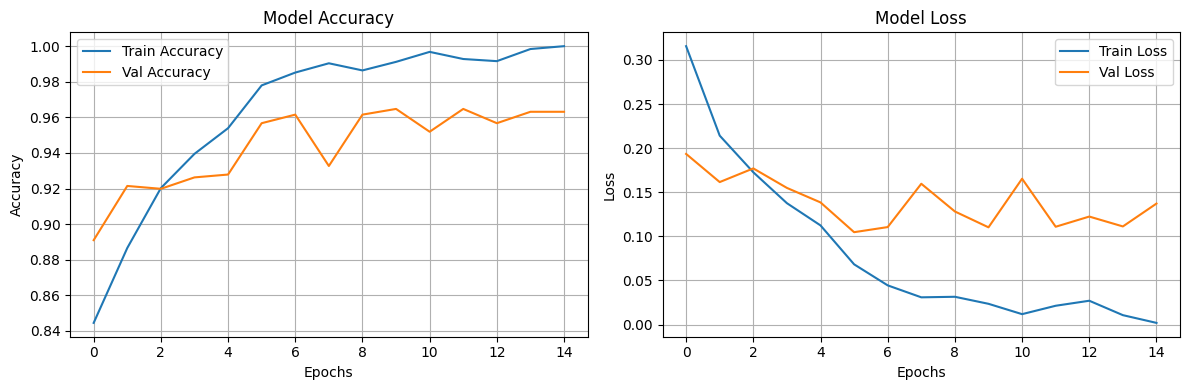

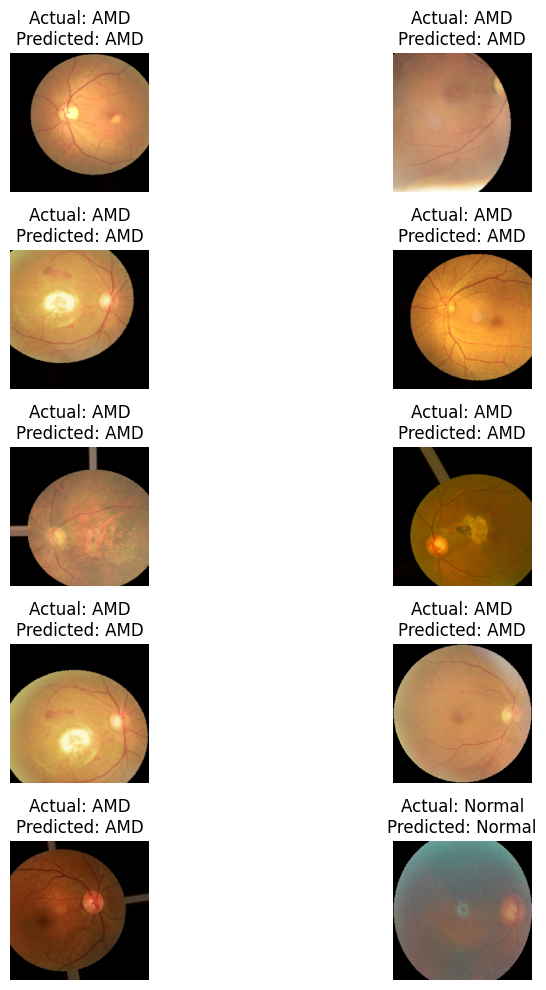

In [ ]:
!pip install -q keras tensorflow Pillow

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/full_df.csv'
df = pd.read_csv(csv_path)

right_AMD = df["Right-Fundus"][df["Right-Diagnostic Keywords"].str.contains("age-related macular degeneration", case=False, na=False)]
right_normal = df["Right-Fundus"][df["Right-Diagnostic Keywords"].str.contains("normal fundus", case=False, na=False)]
left_AMD = df["Left-Fundus"][df["Left-Diagnostic Keywords"].str.contains("age-related macular degeneration", case=False, na=False)]
left_normal = df["Left-Fundus"][df["Left-Diagnostic Keywords"].str.contains("normal fundus", case=False, na=False)]

AMD = list(right_AMD) + list(left_AMD)
normal = list(right_normal) + list(left_normal)

np.random.seed(3)
snormal = np.random.choice(normal, size=600, replace=False)

dataset_dir = "/content/drive/MyDrive/preprocessed_images"
image_size = 224

print("Images in dataset directory:")
print(os.listdir(dataset_dir)[:10])

def process_image(image_path, image_size):
    try:
        img = load_img(image_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def create_dataset(image_list, label):
    data = []
    missing_images = []
    for img_name in image_list:
        image_path = os.path.join(dataset_dir, img_name)
        if not os.path.exists(image_path):
            missing_images.append(image_path)
            continue
        img_array = process_image(image_path, image_size)
        if img_array is not None:
            data.append((img_array, label))
    # Log missing images
    with open("missing_images.log", "w") as log_file:
        for img in missing_images:
            log_file.write(img + "\n")
    return data

AMD_dataset = create_dataset(AMD, 1)
normal_dataset = create_dataset(snormal, 0)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

augmented_data = []
for img, label in AMD_dataset:
    img = np.expand_dims(img, axis=0)
    for _ in range(5):  # Generate 5 augmented images per original image
        aug_img = datagen.flow(img, batch_size=1)[0]
        augmented_data.append((aug_img[0], label))

dataset = AMD_dataset + normal_dataset + augmented_data
np.random.shuffle(dataset)

x_list, y_list = zip(*dataset)
x = np.array(x_list)
y = np.array(y_list)

print(f"Number of AMD images: {len(AMD_dataset)}")
print(f"Number of Normal images: {len(normal_dataset)}")
print(f"Total dataset size: {len(dataset)}")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

vgg_base = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in vgg_base.layers[-4:]:  # Fine-tune the last 4 layers
    layer.trainable = True

input_layer = Input(shape=(224, 224, 3))
x = vgg_base(input_layer, training=False)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation="sigmoid")(x)

model = Model(inputs=input_layer, outputs=output_layer)

class_weights = {0: 1.0, 1: len(snormal) / len(AMD_dataset)}
model.compile(optimizer=Adam(learning_rate=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("vgg19_best.keras", save_best_only=True, monitor="val_accuracy"),
        tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)
    ]
)

model.summary()
model.save("vgg19_model.keras")
evaluation = model.evaluate(x_test, y_test)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

y_pred_prob = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_pred_prob > optimal_threshold).astype("int32")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize predictions
plt.figure(figsize=(10, 10))
for i in range(10):
    idx = np.random.randint(0, len(x_test))
    img = x_test[idx]
    actual_label = "AMD" if y_test[idx] == 1 else "Normal"
    predicted_label = "AMD" if y_pred[idx] == 1 else "Normal"
    plt.subplot(5, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    plt.axis("off")
plt.tight_layout()
plt.show()
